# Tesla Stock Prediction

[Tesla, Inc.](https://en.wikipedia.org/wiki/Tesla,_Inc.) is  is an American multinational automotive and clean energy company headquartered in Austin, Texas, which designs and manufactures electric vehicles (cars and trucks), stationary battery energy storage devices from home to grid-scale, solar panels and solar shingles, and related products and services. In this project, we are going through a dataset containing information about the Tesla stock prices. The data was made avaliable by [kaggle](https://www.kaggle.com/datasets/timoboz/tesla-stock-data-from-2010-to-2020) and our main goal is to predict the stock closing price. This report is divided in 5 parts:

* Setting up the data
* Exploratory data analysis
* Model training
* Model Evaluation
* Conclusion

## Setting up the data

We start our project by loading the required packages and data. The dataset was previously loaded to a BigQuery table.

In [7]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, StratifiedKFold

credentials = service_account.Credentials.from_service_account_file(
'credentials.json')

project_id = 'platinum-factor-405117'
client = bigquery.Client(credentials=credentials,project=project_id)

query = """
   SELECT *
   FROM datascience.tesla_stock
   """
df = pd.read_gbq(query, project_id=project_id, credentials=credentials)
df.tail()

,Date,Open,High,Low,Close,Adj_Close,Volume
2411,2011-04-27,26.93,27.360001,26.629999,27.080000,27.080000,996900
2412,2012-01-30,29.49,29.610001,28.530001,29.570000,29.570000,729000
2413,2011-03-22,22.73,22.860001,22.000000,22.190001,22.190001,582900
2414,2011-10-25,28.23,28.860001,27.799999,28.250000,28.250000,654400
2415,2020-01-21,530.25,548.580017,528.409973,547.200012,547.200012,17803500


We have 2416 rows and 7 columns. According to the data description, each variable is related to the stock in a given moment.

1. Date: Date of the event
2. Open: Opening stock price on the date
3. High: Highest stock price on the date
4. Low: Lowest price on the date
5. Cloce: Closing stock price on the date
6. Adj_Cloce: Adjusted clocing stock price on the date
7. Volume: Trading volume on the date

Let us get some general information from the data and check if there any null values.

In [8]:
df.describe()

,Open,High,Low,Close,Adj_Close,Volume
count,2416.000000,2416.000000,2416.000000,2416.000000,2416.000000,2.416000e+03
mean,186.271147,189.578224,182.916639,186.403651,186.403651,5.572722e+06
std,118.740163,120.892329,116.857591,119.136020,119.136020,4.987809e+06
min,16.139999,16.629999,14.980000,15.800000,15.800000,1.185000e+05
25%,34.342498,34.897501,33.587501,34.400002,34.400002,1.899275e+06
50%,213.035004,216.745002,208.870002,212.960007,212.960007,4.578400e+06
75%,266.450012,270.927513,262.102501,266.774994,266.774994,7.361150e+06
max,673.690002,786.140015,673.520020,780.000000,780.000000,4.706500e+07


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   dbdate 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj_Close  2416 non-null   float64
 6   Volume     2416 non-null   Int64  
dtypes: Int64(1), dbdate(1), float64(5)
memory usage: 134.6 KB


There are no null values. The Date columns is with a dbdate type and the Volume is a Int64 columns. The others are float64 columns. The Close and Adj_Close columns have the same descriptive statistics. Therefore, it is very likely that they are redundant. Let us check that and if it is the case, drop the Adj_Close column. 

In [10]:
sum(df['Close']!=df['Adj_Close'])

0

In [11]:
df = df.drop('Adj_Close', axis=1)
df.tail()

,Date,Open,High,Low,Close,Volume
2411,2011-04-27,26.93,27.360001,26.629999,27.080000,996900
2412,2012-01-30,29.49,29.610001,28.530001,29.570000,729000
2413,2011-03-22,22.73,22.860001,22.000000,22.190001,582900
2414,2011-10-25,28.23,28.860001,27.799999,28.250000,654400
2415,2020-01-21,530.25,548.580017,528.409973,547.200012,17803500


Since we want to predict the closing value based on the date and opening prices, we are only keeping the Date, Open and Close columns. We are also changing the Date column type and extracting some new date columns to help in the data exploratory analysis and in the model training.

In [12]:
df = df[['Date', 'Open', 'Close']]
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Weekday'] = df['Date'].dt.dayofweek
df.tail()

,Date,Open,Close,Year,Month,Day,Weekday
2411,2011-04-27,26.93,27.080000,2011,4,27,2
2412,2012-01-30,29.49,29.570000,2012,1,30,0
2413,2011-03-22,22.73,22.190001,2011,3,22,1
2414,2011-10-25,28.23,28.250000,2011,10,25,1
2415,2020-01-21,530.25,547.200012,2020,1,21,1


Now let us split our dataset into two subsets. One will be used for training and the other one for testing. We will stratify our data by the year, in order to correctly catch any trends caused by inflation, economic growth, etc. We will use 20% of the observations for test.

In [13]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Year'])

df_train['Data'] = 'train'
df_train.tail()

,Date,Open,Close,Year,Month,Day,Weekday,Data
1419,2017-09-07,345.980011,350.609985,2017,9,7,3,train
810,2011-07-28,27.600000,28.170000,2011,7,28,3,train
2318,2014-10-28,229.600006,242.770004,2014,10,28,1,train
1278,2013-06-13,99.000000,98.180000,2013,6,13,3,train
961,2013-04-10,40.700001,41.860001,2013,4,10,2,train


In [14]:
df_test['Data'] = 'test'
df_test.tail()

,Date,Open,Close,Year,Month,Day,Weekday,Data
63,2018-06-22,351.540009,333.630005,2018,6,22,4,test
1413,2011-08-30,24.500000,24.629999,2011,8,30,1,test
1730,2010-08-31,19.660000,19.480000,2010,8,31,1,test
1959,2018-10-01,305.769989,310.700012,2018,10,1,0,test
1172,2014-05-15,189.979996,188.589996,2014,5,15,3,test


Now let us save our tidy data in a BigQuery table and finish this part of the project.

In [15]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.tail()

,Date,Open,Close,Year,Month,Day,Weekday,Data
2411,2018-06-22,351.540009,333.630005,2018,6,22,4,test
2412,2011-08-30,24.500000,24.629999,2011,8,30,1,test
2413,2010-08-31,19.660000,19.480000,2010,8,31,1,test
2414,2018-10-01,305.769989,310.700012,2018,10,1,0,test
2415,2014-05-15,189.979996,188.589996,2014,5,15,3,test


In [16]:
df.to_gbq('datascience.tesla_stock_tidy', project_id=project_id, credentials=credentials)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<?, ?it/s]


## Exploratory data analysis

Let us start this part by loading the training data and plotting the closing stock price by the date. 

In [17]:
query = """select * from datascience.tesla_stock_tidy
            where Data='train'"""

df = pd.read_gbq(query, project_id=project_id, credentials=credentials)
df = df.drop('Data', axis=1)
df.tail()

,Date,Open,Close,Year,Month,Day,Weekday
1927,2019-05-31 00:00:00+00:00,185.100006,185.160004,2019,5,31,4
1928,2015-07-31 00:00:00+00:00,267.600006,266.149994,2015,7,31,4
1929,2014-01-31 00:00:00+00:00,178.850006,181.410004,2014,1,31,4
1930,2020-01-31 00:00:00+00:00,640.000000,650.570007,2020,1,31,4
1931,2017-03-31 00:00:00+00:00,278.730011,278.299988,2017,3,31,4


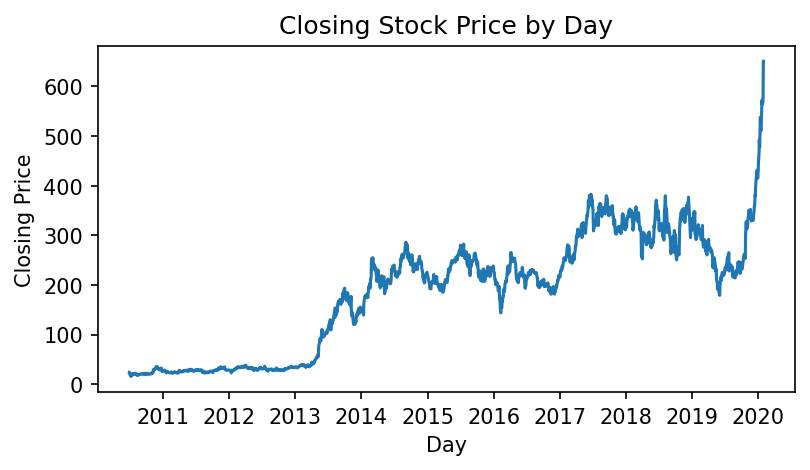

In [25]:
fig, ax = plt.subplots(figsize=(6,3), dpi=150)
sns.lineplot(data=df, x='Date', y='Close', ax=ax)
ax.set_title("Closing Stock Price by Day")
ax.set_xlabel('Day')
ax.set_ylabel("Closing Price")
plt.show()